<a target="_blank" href="https://colab.research.google.com/github/spbisc97/Neural-Lyapunov-Control/blob/master/Inverted%20_Pendulum.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
##Install Dreal if needed
#   %pip install dreal
#   !sudo apt-get install curl
#   !curl -fsSL https://raw.githubusercontent.com/dreal/dreal4/master/setup/ubuntu/20.04/install.sh | sudo bash
%pip install gym[classic_control]import os
os.makedirs("savings", exist_ok=True)
for files in ["frictionpendulum.py", "Functions.py"]:
    if not os.path.exists(files):
        !curl -O https://raw.githubusercontent.com/spbisc97/Neural-Lyapunov-Control/master/{files}

## Learning Lyapunov function for Inverted Pendulum

In [1]:
# -*- coding: utf-8 -*-
from dreal import *
from Functions import *
import torch 
import torch.nn.functional as F
import numpy as np
import timeit 
import matplotlib.pyplot as plt
from datetime import datetime
import os
torch.set_default_dtype(torch.double)

In [2]:

from gym.wrappers.render_collection import RenderCollection
from moviepy.editor import ImageSequenceClip
from IPython.display import Image
import gym
from matplotlib import pyplot
from IPython.display import display, clear_output

## Neural network model
Building NN with random parameters for Lyapunov function and initializing parameters of NN controller to LQR solution

LQR solution is obtained by minimizing the cost function J = ∫(xᵀQx + uᵀRu)dt, where Q is 2×2 identity matrix and R is 1×1 identity matrix

In [3]:
class Net(torch.nn.Module):
    
    def __init__(self,n_input,n_hidden,n_output,lqr):
        super(Net, self).__init__()
        torch.manual_seed(2)
        self.layer1 = torch.nn.Linear(n_input, n_hidden)
        self.layer2 = torch.nn.Linear(n_hidden,n_output)
        self.control = torch.nn.Linear(n_input,1,bias=False)
        self.control.weight = torch.nn.Parameter(lqr)

    def forward(self,x):
        sigmoid = torch.nn.Tanh()
        h_1 = sigmoid(self.layer1(x))
        out = sigmoid(self.layer2(h_1))
        u = self.control(x)
        return out,u

## Dynamical system

In [4]:
def f_value(x,u):
    #Dynamics
    y = []
    G = 9.81  # gravity
    L = 0.5   # length of the pole 
    m = 0.15  # ball mass
    b = 0.1   # friction
    
    for r in range(0,len(x)): 
        f = [ x[r][1], 
              (m*G*L*np.sin(x[r][0])- b*x[r][1]) / (m*L**2)]
        y.append(f) 
    y = torch.tensor(y)
    y[:,1] = y[:,1] + (u[:,0]/(m*L**2))
    return y

## Options

In [5]:
'''
For learning 
'''
N = 500             # sample size
D_in = 2            # input dimension
H1 = 6              # hidden dimension
D_out = 1           # output dimension
torch.manual_seed(10)  
x = torch.Tensor(N, D_in).uniform_(-6, 6)           
x_0 = torch.zeros([1, 2])

'''
For verifying 
'''
x1 = Variable("x1")
x2 = Variable("x2")
vars_ = [x1,x2]
G = 9.81 
l = 0.5  
m = 0.15
b = 0.1
config = Config()
config.use_polytope_in_forall = True
config.use_local_optimization = True
config.precision = 1e-2
epsilon = 0
# Checking candidate V within a ball around the origin (ball_lb ≤ sqrt(∑xᵢ²) ≤ ball_ub)
ball_lb = 0.5
ball_ub = 6



## Learning and Falsification

In [6]:
out_iters = 0
valid = False
set_prev_weight = True

while out_iters < 2 and not valid: 
    datefolder=datetime.now().strftime("%Y%m%d-%H%M%S")
    start = timeit.default_timer()
    lqr = torch.tensor([[-23.58639732,  -5.31421063]])    # lqr solution
    model = Net(D_in,H1, D_out,lqr)
    if (set_prev_weight==True) and (out_iters == 0):
        model.load_state_dict(torch.load('savings/model_pendulum.pth'))
    L = []
    i = 0 
    t = 0
    max_iters = 2000
    learning_rate = 0.01
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    while i < max_iters and not valid: 
        V_candidate, u = model(x)
        X0,u0 = model(x_0)
        f = f_value(x,u)
        Circle_Tuning = Tune(x)
        # Compute lie derivative of V : L_V = ∑∂V/∂xᵢ*fᵢ
        L_V = torch.diagonal(torch.mm(torch.mm(torch.mm(dtanh(V_candidate),model.layer2.weight)\
                            *dtanh(torch.tanh(torch.mm(x,model.layer1.weight.t())+model.layer1.bias)),model.layer1.weight),f.t()),0)

        # With tuning term 
        Lyapunov_risk = (F.relu(-V_candidate)+ 1.5*F.relu(L_V+0.5)).mean()\
                    +2.2*((Circle_Tuning-6*V_candidate).pow(2)).mean()+(X0).pow(2) 
        # Without tuning term
#         Lyapunov_risk = (F.relu(-V_candidate)+ 1.5*F.relu(L_V+0.5)).mean()+ 1.2*(X0).pow(2)
        
        
        print(i, "Lyapunov Risk=",Lyapunov_risk.item()) 
        L.append(Lyapunov_risk.item())
        optimizer.zero_grad()
        Lyapunov_risk.backward()
        optimizer.step() 

        w1 = model.layer1.weight.data.numpy()
        w2 = model.layer2.weight.data.numpy()
        b1 = model.layer1.bias.data.numpy()
        b2 = model.layer2.bias.data.numpy()
        q = model.control.weight.data.numpy()

        # Falsification
        if i % 10 == 0:
            u_NN = (q.item(0)*x1 + q.item(1)*x2) 
            f = [ x2,
                 (m*G*l*sin(x1) + u_NN - b*x2) /(m*l**2)]

            # Candidate V
            z1 = np.dot(vars_,w1.T)+b1

            a1 = []
            for j in range(0,len(z1)):
                a1.append(tanh(z1[j]))
            z2 = np.dot(a1,w2.T)+b2
            V_learn = tanh(z2.item(0))

            print('===========Verifying==========')        
            start_ = timeit.default_timer() 
            result= CheckLyapunov(vars_, f, V_learn, ball_lb, ball_ub, config,epsilon)
            stop_ = timeit.default_timer() 

            if (result): 
                print("Not a Lyapunov function. Found counterexample: ")
                print(result)
                x = AddCounterexamples(x,result,10)
            else:  
                valid = True
                print("Satisfy conditions!!")
                print(V_learn, " is a Lyapunov function.")
            t += (stop_ - start_)
            print('==============================') 
        i += 1

    stop = timeit.default_timer()

    os.mkdir(f"savings/{datefolder}")
    np.savetxt(f"savings/{datefolder}/w1.txt", model.layer1.weight.data, fmt="%s")
    np.savetxt(f"savings/{datefolder}/w2.txt", model.layer2.weight.data, fmt="%s")
    np.savetxt(f"savings/{datefolder}/b1.txt", model.layer1.bias.data, fmt="%s")
    np.savetxt(f"savings/{datefolder}/b2.txt", model.layer2.bias.data, fmt="%s")
    np.savetxt(f"savings/{datefolder}/q.txt", model.control.weight.data, fmt="%s")
    torch.save(model.state_dict(), f'savings/{datefolder}/model_pendulum.pth')
    torch.save(model.state_dict(), f'savings/model_pendulum.pth')



    print('\n')
    print("Total time: ", stop - start)
    print("Verified time: ", t)
    
    out_iters+=1

0 Lyapunov Risk= 0.9608100361788595
===========Verifying==========
Not a Lyapunov function. Found counterexample: 
x1 : [-3.0870312500000008, -3.077031250000001]
x2 : [1.4479571926541186, 1.4579571926541184]
1 Lyapunov Risk= 1.3440423541959765
2 Lyapunov Risk= 0.9455920459405163
3 Lyapunov Risk= 1.0014391323287015
4 Lyapunov Risk= 1.0852978929705517
5 Lyapunov Risk= 1.0864841614854697
6 Lyapunov Risk= 1.039262685980808
7 Lyapunov Risk= 0.9807987690562102
8 Lyapunov Risk= 0.9405352042471677
9 Lyapunov Risk= 0.9268804280398378
10 Lyapunov Risk= 0.9316223324281011
===========Verifying==========
Not a Lyapunov function. Found counterexample: 
x1 : [-0.46875000000000011, -0.46718636359916926]
x2 : [0.24986364060933408, 0.25066339133884741]
11 Lyapunov Risk= 0.9317988468433034
12 Lyapunov Risk= 0.9225728076468523
13 Lyapunov Risk= 0.8994893173434912
14 Lyapunov Risk= 0.8688495055879312
15 Lyapunov Risk= 0.845552385444676
16 Lyapunov Risk= 0.8483058854694049
17 Lyapunov Risk= 0.86526052449956

### Checking result with smaller epsilon ( Lie derivative of V <= epsilon )

In [7]:
epsilon = -0.00001
q = model.control.weight.data.numpy()

f = [ x2,(m*G*l*sin(x1) + u_NN - b*x2) /(m*l**2)]
u_NN = (q.item(0)*x1 + q.item(1)*x2) 

start_ = timeit.default_timer() 
result = CheckLyapunov(vars_, f, V_learn, ball_lb, ball_ub, config, epsilon)
stop_ = timeit.default_timer() 

if (result): 
    print("Not a Lyapunov function. Found counterexample: ")
else:  
    print("Satisfy conditions with epsilon= ",epsilon)
    print(V_learn, " is a Lyapunov function.")
t += (stop_ - start_)

Satisfy conditions with epsilon=  -1e-05
tanh((1.7631794532942844 + 1.1873013016845979 * tanh((-2.0775065495682821 + 0.040150737786855017 * x1 + 0.42621673630265611 * x2)) + 1.4327084106352506 * tanh((-1.3097738291042189 + 0.27699430817388715 * x1 - 0.07003382926080999 * x2)) + 0.99358235082408697 * tanh((-0.34228017407149797 + 0.21883756153983672 * x1 + 0.41951826625729921 * x2)) + 1.4133376396410537 * tanh((-0.15581449984282753 - 0.17117516897150264 * x1 - 0.26601831601028847 * x2)) - 1.4791220934018154 * tanh((1.7941811487473505 + 0.35312916579419756 * x1 + 0.02543078696185987 * x2)) + 2.7403199056372469 * tanh((2.0387602592601475 + 0.012568438162059326 * x1 - 0.030832108782108462 * x2))))  is a Lyapunov function.


### More details on Lyapunov risk
Generally, we start training with Lyapunov risk without the tuning term.      
For example, (1* F.relu(-V_candidate)+ 1.5* F.relu(L_V+0.5)).mean()+ 1.2*(X0).pow(2)    
The weight of each term (1, 1.5, 1.2) can be tuned for balancing each Lyapunov condition.     
Furthermore, using F.relu(L_V+0.5) allows the learning procedure to seek a candidate Lyapunov function with more negative Lie derivative.   
Here 0.5 is also a tunable parameter based on your goal.    
In this example, we use Lyapunov risk with tuning term for achieving large ROA     

In [8]:
eval_env = {x1:0,x2:0}
print(eval_env)
control=V_learn.Evaluate(eval_env)
print(control)

{Variable('x1'): 0, Variable('x2'): 0}
0.07779841743509851


In [9]:
from frictionpendulum import FrictionPendulumEnv
from gym.envs.registration import register
register(
    id='FrictionPendulum-v0',
    entry_point='frictionpendulum:FrictionPendulumEnv',
    max_episode_steps=1000,
    reward_threshold=950.0,
)

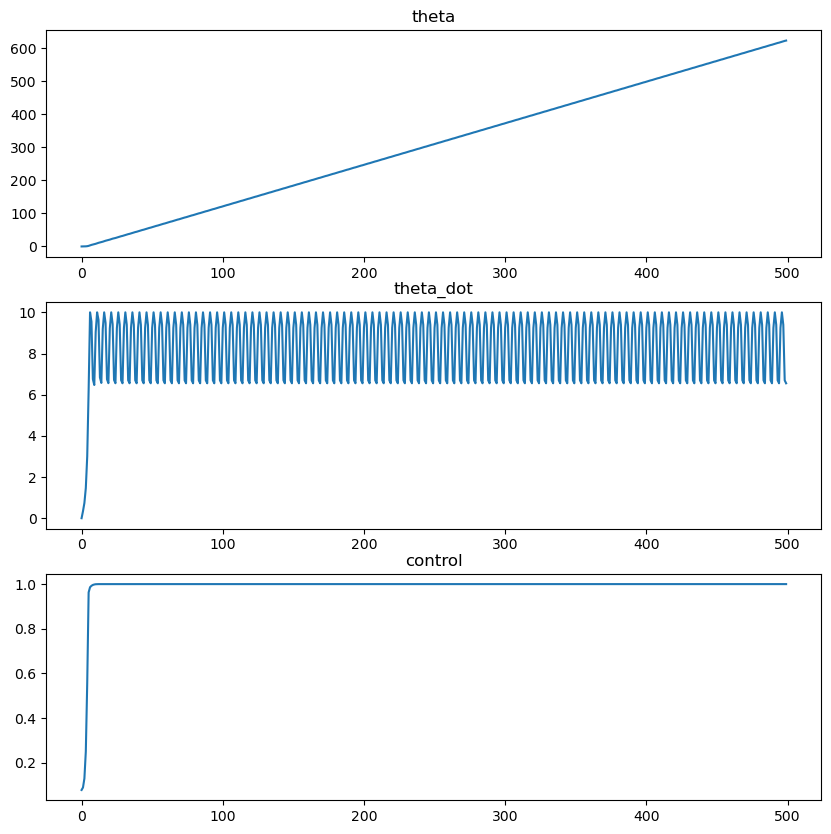

MoviePy - Building file pendulum.gif with imageio.


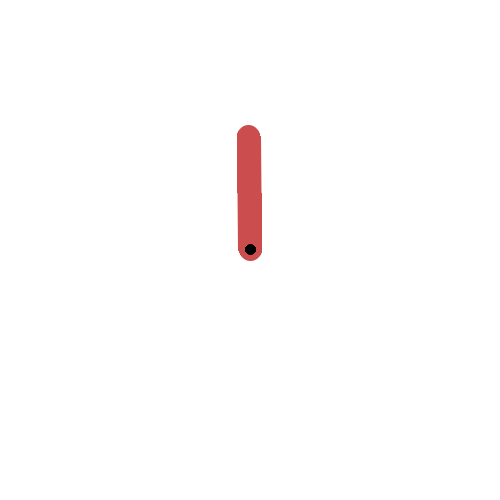

AttributeError: module 'os' has no attribute 'delete'

In [10]:
env=gym.make("FrictionPendulum",render_mode="rgb_array",g=9.81,dt=0.05, m=0.15, L=0.5, b=0.1,max_speed=10,max_torque=3,
             initial_state=np.array([0.01,0])
             )
env=RenderCollection(env)
env.reset()
y1=[]
y2=[]
controls=[]
for i in range(500):
    # env.render()
    eval_env = {x1:env.state[0],x2:env.state[1]}
    control=V_learn.Evaluate(eval_env)
    if i<0:
        control=0
    y1.append(env.state[0])
    y2.append(env.state[1])
    controls.append(control)
    
    env.step(np.array([control]))

frames=env.render()

env.close()
fix,ax=pyplot.subplots(3,1,figsize=(10,10))
ax[0].plot(y1)
ax[0].set_title("theta")
ax[1].plot(y2)
ax[1].set_title("theta_dot")
ax[2].plot(controls)
ax[2].set_title("control")
pyplot.show()
gif=ImageSequenceClip(frames,fps=30)
gif.write_gif("pendulum.gif")
display(Image('pendulum.gif'))
os.remove("pendulum.gif")


In [ ]:
env = gym.make(
    "FrictionPendulum",
    render_mode="rgb_array",
    g=9.81,
    dt=0.05,
    m=0.15,
    L=0.5,
    b=0.1,
    max_speed=10,
    max_torque=5,
    initial_state=np.array([0.4, 0]),
)
env = RenderCollection(env)
env.reset()
lqr = np.array([-2, -0.1])
y1 = []
y2 = []
controls = []
for i in range(500):
    # env.render()
    control = lqr[0]* env.state[0]+ lqr[1] * env.state[1]
    if i < 0:
        control = 0
    y1.append(env.state[0])
    y2.append(env.state[1])
    controls.append(control)

    env.step(np.array([control]))

frames = env.render()

env.close()
fix, ax = pyplot.subplots(3, 1, figsize=(10, 10))
ax[0].plot(y1)
ax[0].set_title("theta")
ax[1].plot(y2)
ax[1].set_title("theta_dot")
ax[2].plot(controls)
ax[2].set_title("control")
pyplot.show()
gif = ImageSequenceClip(frames, fps=30)
gif.write_gif("pendulum.gif")
display(Image("pendulum.gif"))
os.remove('pendulum.gif')